In [63]:
import requests
import numpy as np
from config import *
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import os
import json

from dateutil.relativedelta import relativedelta
from docopt import docopt #해당 모듈을 어떻게 쓸지 자동으로 알려 줌


#rc('font', family='AppleGothic')

#plt.rcParams['axes.unicode_minus'] = False

font_path = "C:/Windows/Fonts/malgun.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
plt.rcParams['axes.unicode_minus'] = False


In [64]:
def df_plotting(df, title='Insert Title'):

    column_idx = df.columns.to_list()
    time_idx = df.index.to_list()

    plt.figure(figsize=(14,8))
    
    for i in column_idx:
        plt.plot(time_idx, df[i], label=i)

    plt.title(title, size=30)
    plt.legend()
    plt.show()

In [65]:
def daily_news_df(date_from, date_to):
    
    date_from = dt.datetime.strptime(date_from, '%Y-%m-%d').isoformat()[0:10]
    date_to = dt.datetime.strptime(date_to, '%Y-%m-%d').isoformat()[0:10]

    #date_interval = list(pd.date_range(dt.datetime.strptime(date_from, '%Y-%m-%d'), dt.datetime.strptime(date_to, '%Y-%m-%d'), freq='d'))  

    url = f"{ELASTIC_SEARCH_URL}/news/_search"

    query_day = {
        "size": 0,
            "query":{
                "range":{
                "created_at": {
                    "gte": date_from,
                    "lte": date_to
                    }
                }
            },
            "aggs": {
                "group_by_date":{
                "date_histogram": {
                    "field": "created_at",
                    "interval": "day"
                }
            }
        }
    }

    headers = {
        'Content-Type' : 'application/json'
    }

    resp = requests.get(
        url,
        data=json.dumps(query_day),
        headers=headers,
        auth= ELASTIC_SEARCH_AUTH
    )

    data = resp.json()

    daily = data['aggregations']['group_by_date']['buckets']
    df_daily = pd.DataFrame(data = daily)[['key_as_string', 'doc_count']]
    df_daily = df_daily.rename(columns={"key_as_string" : "date"})
    df_daily['date'] = pd.to_datetime(df_daily['date'])
    df_daily = df_daily.set_index('date')

    return df_daily

In [66]:
df = daily_news_df("2022-05-01", "2022-05-31")

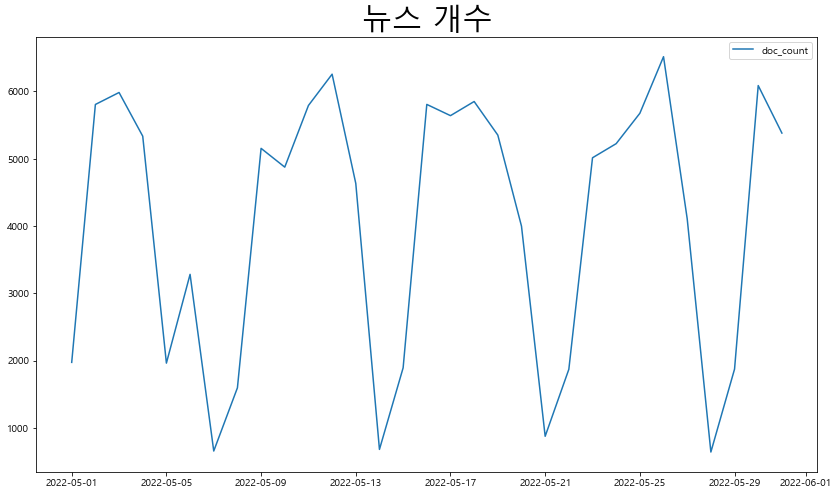

In [68]:
df_plotting(df, "뉴스 개수")

# 2. Top5 언론사 리스트 변수로 받아 각 날짜 별로 언론사 기사 갯수 time-series chart 출력

## Top5 언론사

In [69]:
def top_publisher(num_of_publisher, date_from, date_to):
    
    date_from = dt.datetime.strptime(date_from, '%Y-%m-%d').isoformat()[0:10]
    date_to = dt.datetime.strptime(date_to, '%Y-%m-%d').isoformat()[0:10]

    url = f"{ELASTIC_SEARCH_URL}/news/_search"

    query_publisher = {
    "size": 0,
        "query":{
            "range":{
                "created_at": {
                    "gte": date_from,
                    "lte": date_to
                    }
                }
            },
    "aggs": {
        "group_by_publisher":{
            "terms": {
                "field": "publisher.keyword",
                "size": num_of_publisher
                }
            }
        }
    }

    headers = {
        'Content-Type' : 'application/json'
    }

    resp = requests.get(
        url,
        data=json.dumps(query_publisher),
        headers=headers,
        auth= ELASTIC_SEARCH_AUTH
    )

    data = resp.json()

    dict = data['aggregations']['group_by_publisher']['buckets']

    df = pd.DataFrame(data=dict)

    # publisher_list = []
    # for i in range(len(dict)):
    #     publisher_list.append(dict[i]['key'])

    return df['key'].to_list()

In [70]:
top_publisher(5, "2022-05-01", "2022-05-31")

['뉴스1', '뉴시스', '연합뉴스', '이데일리', '파이낸셜뉴스']

In [71]:
def publisher_daily_news_trend (publisher_list, date_from, date_to):
    
    time_idx = daily_news_df(date_from, date_to).index.to_list()

    date_from = dt.datetime.strptime(date_from, '%Y-%m-%d').isoformat()[0:10]
    date_to = dt.datetime.strptime(date_to, '%Y-%m-%d').isoformat()[0:10]

    df = pd.DataFrame(index=time_idx)

    url = f"{ELASTIC_SEARCH_URL}/news/_search"

    headers = {
    'Content-Type' : 'application/json'
    }


    for keyword in publisher_list:
        query = {
            "size": 0,
            "query":{
                "range":{
                    "created_at": {
                        "gte": date_from,
                        "lte": date_to
                        }
                    }
                },
                "aggs": {
                    "group_by_date":{
                        "date_histogram": {
                            "field": "created_at",
                            "interval": "day"
                        }
                    }
                },
                "query":{
                    "match":{
                    "publisher": keyword
                    }
                }
        }
        
        resp = requests.get(
            url,
            data=json.dumps(query),
            headers=headers,
            auth= ELASTIC_SEARCH_AUTH
        )

        data = resp.json()
        data = data['aggregations']['group_by_date']['buckets']
        df_tmp = pd.DataFrame(data = data)[['key_as_string', 'doc_count']]
        df_tmp = df_tmp.rename(columns={"key_as_string" : "date"})
        df_tmp['date'] = pd.to_datetime(df_tmp['date'])
        df_tmp = df_tmp.set_index('date')

        df[keyword] = df_tmp['doc_count']


    return df
    

In [72]:
publisher_daily_news_trend(top_publisher(5, "2022-05-01", "2022-05-31"), "2022-05-01", "2022-05-31")

,뉴스1,뉴시스,연합뉴스,이데일리,파이낸셜뉴스
2022-05-01 00:00:00+00:00,217,161,178,136,128
2022-05-02 00:00:00+00:00,471,500,406,443,353
2022-05-03 00:00:00+00:00,528,580,461,494,316
2022-05-04 00:00:00+00:00,501,403,403,400,293
2022-05-05 00:00:00+00:00,116,128,162,100,99
2022-05-06 00:00:00+00:00,279,284,263,278,123
2022-05-07 00:00:00+00:00,45,50,39,48,26
2022-05-08 00:00:00+00:00,104,103,125,89,110
2022-05-09 00:00:00+00:00,446,420,378,385,288
2022-05-10 00:00:00+00:00,390,393,375,414,287


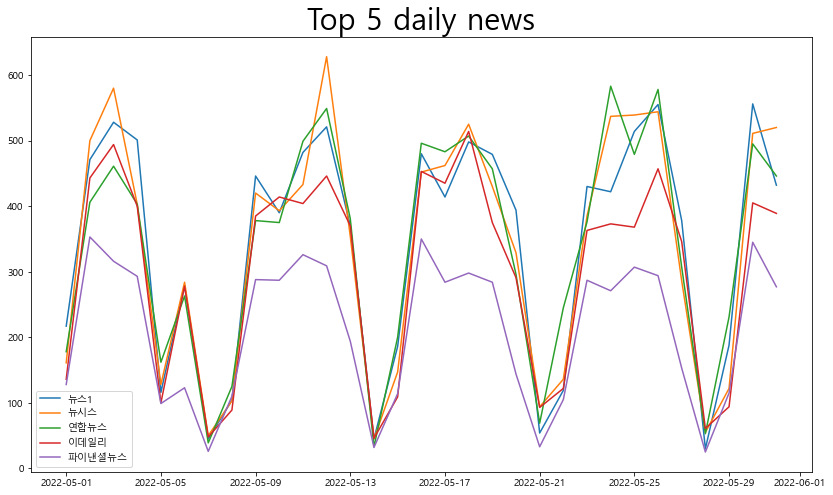

In [98]:
df_plotting(publisher_daily_news_trend(top_publisher(5, "2022-05-01", "2022-05-31"), "2022-05-01", "2022-05-31"),"Top 5 daily news")

# 3. 키워드 리스트를 변수로 받아 키워드별 일별 기사 갯수 & 비율 출력

In [74]:
def keyword_daily_news_trend (keyword_list, date_from, date_to):

    time_idx = daily_news_df(date_from, date_to).index.to_list()

    date_from = dt.datetime.strptime(date_from, '%Y-%m-%d').isoformat()[0:10]
    date_to = dt.datetime.strptime(date_to, '%Y-%m-%d').isoformat()[0:10]

    df = pd.DataFrame(index=time_idx)

    url = f"{ELASTIC_SEARCH_URL}/news/_search"

    headers = {
    'Content-Type' : 'application/json'
    }


    for keyword in keyword_list:
        query = {
                "size": 0,
                    "query":{
                        "range":{
                        "created_at": {
                            "gte": date_from,
                            "lte": date_to
                            }
                        }
                },
                "aggs": {
                    "group_by_date":{
                        "date_histogram": {
                            "field": "created_at",
                            "interval": "day"
                        }
                    }
                },
                "query":{
                    "match":{
                    "body": keyword
                    }
                }
            }

        resp = requests.get(
            url,
            data=json.dumps(query),
            headers=headers,
            auth= ELASTIC_SEARCH_AUTH
        )

        data = resp.json()
        data = data['aggregations']['group_by_date']['buckets']
        df_tmp = pd.DataFrame(data = data)[['key_as_string', 'doc_count']]
        df_tmp = df_tmp.rename(columns={"key_as_string" : "date"})
        df_tmp['date'] = pd.to_datetime(df_tmp['date'])
        df_tmp = df_tmp.set_index('date')

        df[keyword] = df_tmp['doc_count']

    
    df = df.fillna(0)

    return df
    

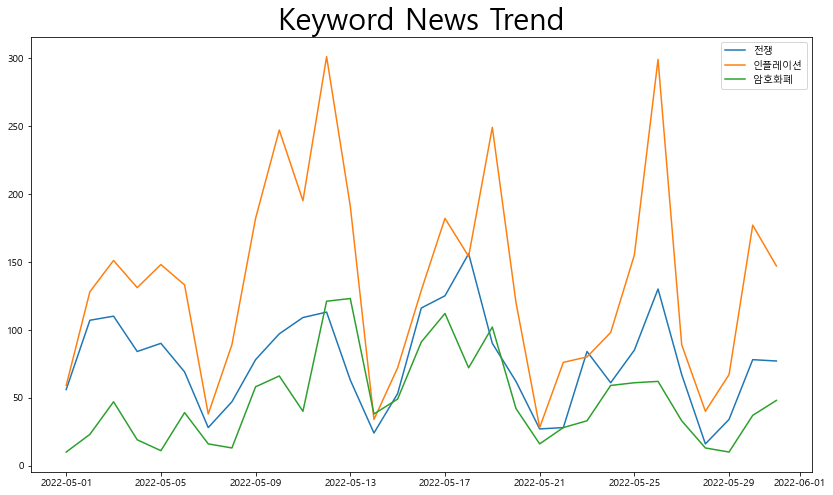

In [76]:
df_plotting(keyword_daily_news_trend(['전쟁', '인플레이션', '암호화폐'], "2022-05-01", "2022-05-31"), "Keyword News Trend")

# 4. 날짜별로 뉴스 Title 크롤링해서 리스트로 정리

In [84]:
def fetch_news_docs(date_from, date_to, page):
    
    date_from = date_from.isoformat()[0:10]
    date_to = date_to.isoformat()[0:10]

    query = {
        "query": {
            "range":{
                "created_at": {
                    "gte": date_from,
                    "lte": date_to
                }
            }
        },
        "size": 10,
        "from": page * 10
    }

    headers = {
        'Content-Type': 'application/json'
    }

    resp = requests.get(
        f'{ELASTIC_SEARCH_URL}/news/_search',
        headers = headers,
        data = json.dumps(query),
        auth = ELASTIC_SEARCH_AUTH
    )

    assert resp.status_code == 200

    data = json.loads(resp.text)
    hits = data['hits']['hits']

    return hits

def get_titles(hits):

    return hits['_source']['title']

def download_total_title (date_from, date_to):

    date_from = dt.datetime.strptime(date_from, '%Y-%m-%d').isoformat()[0:10]
    date_to = dt.datetime.strptime(date_to, '%Y-%m-%d').isoformat()[0:10]

    date_interval = list(pd.date_range(date_from, date_to, freq='d'))

    print("Downloading data from OpenSearch server")

    total_title_list = []

    for i in range(len(date_interval)):

        str_date = date_interval[i].strftime('%Y-%m-%d')

        print(f"{str_date} Start!")

        daily_title_list = []

        start_date = date_interval[i]
        end_date = date_interval[i] + relativedelta(days=1)

        for page in range(1000):

#            print('.', end='', flush=True)

            hits = fetch_news_docs(start_date, end_date, page)

            if len(hits) == 0:
                break

            for doc in hits:
            
                daily_title_list.append(get_titles(doc))

        total_title_list.append(daily_title_list)

        print("***" + str_date + "End!" + "***")

    print("Daily Data end!")

    return total_title_list

def total_title_show (total_title_list, date_from, date_to):

    date_from = dt.datetime.strptime(date_from, '%Y-%m-%d').isoformat()[0:10]
    date_to = dt.datetime.strptime(date_to, '%Y-%m-%d').isoformat()[0:10]

    date_interval = list(pd.date_range(date_from, date_to, freq='d'))

    for i in range(len(date_interval)):

        str_date = date_interval[i].strftime('%Y-%m-%d')

        print(str_date)
        print(total_title_list[i] + '\n')

    #return date_interval

def txt_title_save (total_title_list, date_from, date_to):

    date_from = dt.datetime.strptime(date_from, '%Y-%m-%d').isoformat()[0:10]
    date_to = dt.datetime.strptime(date_to, '%Y-%m-%d').isoformat()[0:10]

    date_interval = list(pd.date_range(date_from, date_to, freq='d'))

    with open('title_list_allday.txt','w',encoding='UTF-8') as f:

        for i in range(len(total_title_list)):
        
            str_date = date_interval[i].strftime('%Y-%m-%d')

            f.write('\n' + '[' + str_date + ']' + '\n\n')
        
            for titles in total_title_list[i]:

                f.write(titles + '\n')

In [93]:
daily_news_title = download_total_title('2022-05-01', '2022-05-31')

2022-05-01 Start!
***2022-05-01End!***
2022-05-02 Start!
***2022-05-02End!***
2022-05-03 Start!
***2022-05-03End!***
2022-05-04 Start!
***2022-05-04End!***
2022-05-05 Start!
***2022-05-05End!***
2022-05-06 Start!
***2022-05-06End!***
2022-05-07 Start!
***2022-05-07End!***
2022-05-08 Start!
***2022-05-08End!***
2022-05-09 Start!
***2022-05-09End!***
2022-05-10 Start!
***2022-05-10End!***
2022-05-11 Start!
***2022-05-11End!***
2022-05-12 Start!
***2022-05-12End!***
2022-05-13 Start!
***2022-05-13End!***
2022-05-14 Start!
***2022-05-14End!***
2022-05-15 Start!
***2022-05-15End!***
2022-05-16 Start!
***2022-05-16End!***
2022-05-17 Start!
***2022-05-17End!***
2022-05-18 Start!
***2022-05-18End!***
2022-05-19 Start!
***2022-05-19End!***
2022-05-20 Start!
***2022-05-20End!***
2022-05-21 Start!
***2022-05-21End!***
2022-05-22 Start!
***2022-05-22End!***
2022-05-23 Start!
***2022-05-23End!***
2022-05-24 Start!
***2022-05-24End!***
2022-05-25 Start!
***2022-05-25End!***
2022-05-26 Start!
***2022

In [94]:
daily_news_title

[['`그린 파이낸싱` 잰걸음...한국씨티은행 ESG 행보',
  '아시아나항공, 게이트 그룹 고소…"기내식 독점 공급권 헐값"',
  "[포커스] 위기의 한국 반도체…대만은 약진, 韓은 '빨간불'",
  '인덱스핑거, 학교 커뮤니티 플랫폼 ‘지금우리’ 선보여',
  '암초 만난 ‘망 사용료 의무화 법안’ [경제 블로그]',
  "로봇 동료와 함께 일하는 시대 개막...택배·소독·요리도 '척척'",
  '부산시, 롯데타워 경관심의 유보…임시사용 연장 위태',
  '초·중·고교 도보권 ‘창원 롯데캐슬 어반포레’',
  "무면허 고교생 훔친차 몰다 사고낸 뒤 도주…동승자 '의식불명'",
  '네스프레소, 커피 한 잔으로 파리·이스탄불·리우데자이네루를',
  '“5월 말까지 양도세 신고·납부하세요”',
  '유류세 인하 30% 확대 첫날..."가격은 그대로?"',
  '대출금, 더 길게 빌려드립니다',
  'LG이노텍 이역상씨, 근로자의 날 ‘금탑산업훈장’',
  '10곳중 6곳 기대이상 실적…2분기는 안갯속',
  '신문·달러 윤전기 형상화한 서울머니쇼 NFT 소장하세요',
  '아시아나항공, 기내식 공급사 경영진 고소…"박삼구 배임 공모"',
  '‘횡령’ 우리은행 직원, 검거 전 해외송금 시도…동생도 구속',
  'HDC현산, 이문3구역 시공권 유지…"시공권 배제 투표 부결"',
  '증시 덮친 인플레 공포… "실적·식음료·리츠가 피난처"',
  '코스닥 60개사 투자 주의 ‘환기종목’ 지정',
  '애플, 단기 실적 우려에도…"아이폰이 주가 끌어 올릴 것"',
  '[EcoKnow] 국화와 칼',
  "'유류세 인하 30% 확대' 첫날…체감 효과 얼마나?",
  '한전-포스코홀딩스-롯데케미칼, 수소·암모니아 사업 협력',
  'GS칼텍스·포스코인터 ‘친환경 바이오사업’ 강화',
  '‘매일 5만 톤’ 한강물로 전력 만들어 친환경 냉난방',
  '유류세 인하했다는데…우리동네 주유소 기름값 그대로인 이유는',
  '10년간 나눠 갚는 신용대출 출시... DSR에

In [95]:
txt_title_save(daily_news_title, '2022-05-01', '2022-05-31')

# 각 날짜별로 주요 이슈 Top 3 요약

In [91]:
import nltk
import datetime as dt
import pdb

from collections import defaultdict
from sklearn.pipeline import Pipeline

from es_corpus_reader import EsCorpusReader
from korean_text_normalizer import KoreanTextNormalizer
from gensim_vectorizer import GensimTfidVectorizer
    
def classification_top_n(count_dict, n=3):
    
    for group in range(len(count_dict)):
        count_dict[group].sort()

    top_n = dict(sorted(count_dict.items(), reverse=True, key=lambda x: len(x[1]))[:n])

    i = 1

    for key in top_n.keys():
    
        print(f"*** TOP {i} Section ***")
        
        for idx, content in enumerate(top_n[key]):
            
            if idx < 5:
                print(f"{content}")
            else:
                pass
        i += 1

def daily_k_means_top3(date_from, date_to):

    date_from = dt.datetime.strptime(date_from, '%Y-%m-%d').astimezone(dt.timezone.utc) + dt.timedelta(hours=9)
    date_to = dt.datetime.strptime(date_to, '%Y-%m-%d').astimezone(dt.timezone.utc) + dt.timedelta(hours=9)

    date_interval = list(pd.date_range(date_from, date_to, freq='d'))

    total_doc_count = daily_news_df(date_from.isoformat()[0:10], date_to.isoformat()[0:10])

    for time in date_interval:

        str_time = time.strftime('%Y-%m-%d')

        reader = EsCorpusReader(date_from=time)

        doc_num = total_doc_count.loc[time]['doc_count']
 
        corpus = list(reader.titles(n=doc_num))


        model = Pipeline([
            ('normalizer', KoreanTextNormalizer()),
            ('vectorizer', GensimTfidVectorizer())
        ])

        vectors = model.fit_transform(corpus)

        num_means = 20
        distance = nltk.cluster.cosine_distance

        kmeans = nltk.cluster.KMeansClusterer(
            num_means=num_means,
            distance=distance,
            avoid_empty_clusters=True
        )

        kmeans.cluster(vectors)

        classified = defaultdict(list)

        for doc, vec in zip(corpus, vectors):
            group = kmeans.classify(vec)
            mean = kmeans.means()[group]
            dist = distance(vec, mean)

            entry = (dist, doc)

            classified[group].append(entry)

        print(f"-------- {str_time}'s TOP 3 ISSUES --------")
        classification_top_n(classified, n=3)
        print("\n")
        
        # for group in range(len(classified)):
        #     print(f'*** Group {group} ***')

        #     classified[group].sort() #작은거에서 큰걸로 그룹안에 점수 정렬함 (양극단값이 아래로 내려가고 중앙값이 가운데로 올라옴)

        #     print("Topic Size: {}".format(len(classified[group])))

        #     for idx, x in enumerate(classified[group]):
        #         print(f'{idx}: {x}')

        #         if idx > 5:
        #             break

        #     print()

    # return classified



In [96]:
daily_k_means_top3('2022-05-01', '2022-05-31')

-------- 2022-05-01's TOP 3 ISSUES --------
*** TOP 1 Section ***
(0.7053587121012797, "[포토] 코지마, '2022 브랜드 고객충성도 대상' 안마의자 부문 수상")
(0.7242272479570613, "[포토] 게보린, '2022 브랜드 고객충성도 대상' 진통제 부문 수상")
(0.7242272479570613, "[포토] 닥터방기원, '2022 브랜드 고객충성도 대상' 탈모샴푸 부문 수상")
(0.7242272479570613, "[포토] 메이킨Q, '2022 브랜드 고객충성도 대상' 변비약 부문 수상")
(0.7242272479570613, "[포토] 왓챠, '2022 브랜드 고객충성도 대상' OTT 부문 수상")
*** TOP 2 Section ***
(0.5412528100115551, '[특징주] 한샘, 1분기 영업익 60% 감소 소식에 6%대 약세')
(0.5815486886480198, '[특징주] 한샘, 1분기 영업이익 60% 감소…주가 5%대 하락')
(0.587143010777156, 'DL이앤씨 1분기 영업익 1257억원…전년 대비 37.1% 감소')
(0.5884999346826831, '코오롱인더, 1분기 매출 전년 대비 19%↑…영업익은 원자재 영향에 11%↓')
(0.6179578621759184, '코오롱인더, 1분기 영업익 639억…전년比 11.1% 감소')
*** TOP 3 Section ***
(0.5824781071631311, '대내외 커지는 불안에…투자 없이 현금 쌓았다')
(0.6679042069344642, '4월 역대 최고수출에도, 무역수지 -27억 달러 적자 커졌다')
(0.6814791878889219, '신한금융투자, 이마트24와 ‘열어보니 미국주식’ 이벤트')
(0.6870009657296395, '신한금융투자, 이마트24와 ‘열어보니 미국주식 이벤트’ 실시')
(0.6974372272737819, "[게시판] 신한금융투자, 이마트24와 

# 키워드 날짜 별로 주요 이슈 요약

In [293]:
def daily_k_means_top3(date_from, date_to):

    date_from = dt.datetime.strptime(date_from, '%Y-%m-%d').astimezone(dt.timezone.utc) + dt.timedelta(hours=9)
    date_to = dt.datetime.strptime(date_to, '%Y-%m-%d').astimezone(dt.timezone.utc) + dt.timedelta(hours=9)

    date_interval = list(pd.date_range(date_from, date_to, freq='d'))

    total_doc_count = daily_news_df()

    for time in date_interval:

        str_time = time.strftime('%Y-%m-%d')

        reader = EsCorpusReader(date_from=time)

        doc_num = total_doc_count.loc[time]['doc_count']
 
        corpus = list(reader.titles(n=doc_num))


        model = Pipeline([
            ('normalizer', KoreanTextNormalizer()),
            ('vectorizer', GensimTfidVectorizer())
        ])

        vectors = model.fit_transform(corpus)

        num_means = 20
        distance = nltk.cluster.cosine_distance

        kmeans = nltk.cluster.KMeansClusterer(
            num_means=num_means,
            distance=distance,
            avoid_empty_clusters=True
        )

        kmeans.cluster(vectors)

        classified = defaultdict(list)

        for doc, vec in zip(corpus, vectors):
            group = kmeans.classify(vec)
            mean = kmeans.means()[group]
            dist = distance(vec, mean)

            entry = (dist, doc)

            classified[group].append(entry)

        print(f"-------- {str_time}'s TOP 3 ISSUES --------")
        classification_top_n(classified, n=3)
        print("\n")

In [278]:
def fetch_news_docs_with_keyword (date_from, date_to, page, keyword):
    
    query = {
        "query": {
            "bool": {
                "must":[
                    {
                        "match":{
                            "body": keyword
                        }
                    },
                {
                    "range":{
                        "created_at": {
                            "gte": date_from.isoformat(),
                            "lt": date_to.isoformat()
                            }
                        }
                    }
                ]
            },
        },
        "size": 10,
        "from": page * 10
    }

    headers = {
        'Content-Type': 'application/json'
    }

    resp = requests.get(
        f'{ELASTIC_SEARCH_URL}/news/_search',
        headers = headers,
        data = json.dumps(query),
        auth = ELASTIC_SEARCH_AUTH
    )

    assert resp.status_code == 200

    data = json.loads(resp.text)
    hits = data['hits']['hits']

    return hits

In [280]:
fetch_news_docs_with_keyword(dt.datetime(2022, 4, 1), dt.datetime(2022, 4, 2), 10, "인플레이션")

[{'_index': 'news',
  '_type': '_doc',
  '_id': '009-0004943767',
  '_score': 3.9208546,
  '_source': {'title': '1분기 코스피, 보험·건설·항공株 날았다',
   'section': 'economy',
   'naver_url': 'https://n.news.naver.com/mnews/article/009/0004943767?sid=101',
   'source_url': 'http://news.mk.co.kr/newsRead.php?no=296169&year=2022',
   'image_urls': ['https://imgnews.pstatic.net/image/009/2022/04/01/0004943767_001_20220401195201051.jpg?type=w647'],
   'publisher': '매일경제',
   'created_at': '2022-04-01T17:46:02',
   'updated_at': '2022-04-01T19:52:01',
   'reporter_name': '차창희',
   'reporter_email': 'charming91@mk.co.kr',
   'body': "금리인상기 대표 수혜주\n메리츠화재 36% 상승\n주택 250만가구 공급 호재\n대우건설·GS건설도 올라\n저비용항공사도 수급 개선\n게임·2차전지株는 큰폭 하락\n올해 1분기 국내 증시의 승자는 실적·정책 모멘텀을 등에 업은 보험·건설·항공주였다. 반면 게임주와 2차전지(배터리) 소재주는 실적 불확실성으로 부진을 면치 못했다.\n1일 금융정보 업체 에프앤가이드에 따르면 시가총액 5000억원 이상 상장사 가운데 올해 초부터 지난 3월까지 주가 상승률이 가장 돋보이는 업종은 보험이었다. 보험주 선두 주자는 메리츠화재로 해당 기간에 주가가 36.07% 상승했다. 자사주 취득과 소각으로 주주가치 제고에 앞장서고 있는 메리츠화재는 지난 2월에도 1000억원 규모 자기주식 취

# My Portfolio